In [1]:
import psycopg2
import config as creds
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
from datetime import datetime

CONNECT TO DATABASE:

In [2]:
user=creds.PGUSER
password=creds.PGPASSWORD
host=creds.PGHOST
port=5432
database=creds.PGDATABASE

engine_str=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(engine_str)
conn = engine.raw_connection()
print('Connected')
cur = conn.cursor()
print('Cursor created')

Connected
Cursor created


EXTRACT DATASET:

In [3]:
#First will try modeling ELECTRICITY for all years, all BUILDING TYPES 
#Foreign keys: will One Hot encode categorical feature WARD, excluding DCREALPROPERTYID and YEARBUILT 
#Numeric features: taxrecordfloorarea, awnd, cldd, htdd, tavg, wdf2, wdf5, wsf2, wsf5 
#Target feature: kbtu, and not intensity (kbtupersqft)

query='''
SELECT b.kbtu
      ,b.taxrecordfloorarea
      ,b.ward
      ,b.primarypropertytype_selfselect
      ,b.elegas
      ,n.awnd
      ,n.cldd
      ,n.htdd
      ,n.tavg
      ,n.wdf2
      ,n.wdf5
      ,n.wsf2
      ,n.wsf5
      ,n.date 
FROM buildings_data b
LEFT OUTER join noaa_data n
ON b.REPORTINGYEAR = n.WEATHERYEAR
WHERE b.MONTH = n.MONTH
AND b.ELEGAS = 'E'
--AND b.PRIMARYPROPERTYTYPE_SELFSELECT = '14'
--AND b.REPORTINGYEAR = 2019
AND b.YEARBUILT > 0;
'''

data=pd.read_sql(query,conn)
data.head()

,kbtu,taxrecordfloorarea,ward,primarypropertytype_selfselect,elegas,awnd,cldd,htdd,tavg,wdf2,wdf5,wsf2,wsf5,date
0,0.0,771856.0,3,7,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
1,0.0,222077.0,1,2,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
2,0.0,419406.0,1,7,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
3,0.0,823803.0,5,6,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
4,0.0,365946.0,3,7,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01


In [4]:
data.isnull().values.any()

False

FORMAT COLUMNS:

In [5]:
#CONVERT 'Date' COLUMN TO datetime format

#data["reportingyear"] = data["reportingyear"].astype(str)
#data['month']=data['month'].apply(lambda x: '{0:0>2}'.format(x))
#data['date_time'] = data[['reportingyear', 'month']].agg('-'.join, axis=1)
#data['date_time'] = (data.date_time + "-01")
#data['date_time'] = datetime.strptime('date_time', "%Y-%m-%d")
data['datetime']=pd.to_datetime(data['date'])

In [6]:
data['primarypropertytype_selfselect']=data['primarypropertytype_selfselect'].astype('object')

In [7]:
data.set_index('datetime', inplace=True)
data.head()

,kbtu,taxrecordfloorarea,ward,primarypropertytype_selfselect,elegas,awnd,cldd,htdd,tavg,wdf2,wdf5,wsf2,wsf5,date
datetime,,,,,,,,,,,,,,
2011-01-01,0.0,771856.0,3,7,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
2011-01-01,0.0,222077.0,1,2,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
2011-01-01,0.0,419406.0,1,7,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
2011-01-01,0.0,823803.0,5,6,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01
2011-01-01,0.0,365946.0,3,7,E,8.5,0.0,972.0,33.7,280.0,20.0,29.1,41.0,2011-01


In [8]:
data.columns

Index(['kbtu', 'taxrecordfloorarea', 'ward', 'primarypropertytype_selfselect',
       'elegas', 'awnd', 'cldd', 'htdd', 'tavg', 'wdf2', 'wdf5', 'wsf2',
       'wsf5', 'date'],
      dtype='object')

In [9]:
data.dtypes

kbtu                              float64
taxrecordfloorarea                float64
ward                                int64
primarypropertytype_selfselect     object
elegas                             object
awnd                              float64
cldd                              float64
htdd                              float64
tavg                              float64
wdf2                              float64
wdf5                              float64
wsf2                              float64
wsf5                              float64
date                               object
dtype: object

<AxesSubplot:>

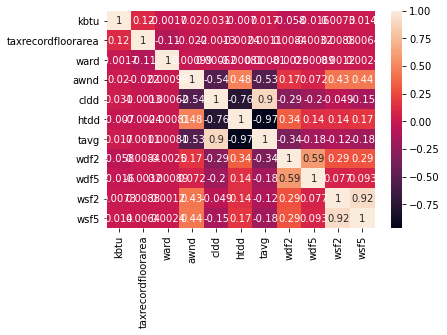

In [11]:
import seaborn as sns
ftr = list(["kbtu", "date", "taxrecordfloorarea", "ward", "awnd", "cldd", "htdd", "tavg","wdf2", "wdf5", "wsf2","wsf5"])
corrMatrix = data[ftr].corr()
sns.heatmap(corrMatrix, annot=True)

DEFINE FEATURES:

In [12]:
#Dropped building type

TARGET = "kbtu"
COLS = ['ward', 'awnd',
       'cldd', 'htdd', 'tavg','wdf2', 'wdf5', 'wsf2','wsf5', 'datetime']

def make_sklearn_data(df=data, target=TARGET, cols=COLS):
    df = df.reset_index()
    X, y = df[cols], df[target]
    return X, y

<AxesSubplot:xlabel='datetime_cos', ylabel='datetime_sin'>

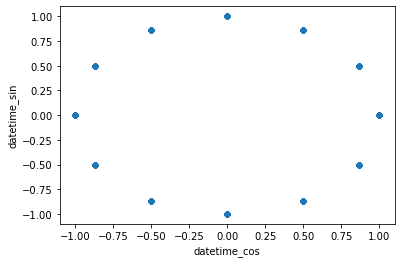

In [13]:
#CYCLIC ENCODER:  to capture temporal cycles (yearly).
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_extract="month"):
        if date_extract not in {"minute", "hour", "week", "month", "year"}:
            raise ValueError(f"specify correct date component to extract, not {date_extract}")
        self.date_extract = date_extract
    
    def get_date_component(self, x):
        if self.date_extract == "month":
            return x.dt.month
        elif self.date_extract == "year":
            return x.dt.year
        else:
            raise NotImplementedError(f"{self.date_extract} date component not implemented yet")
            
    def fit(self, X, y=None):
        self.cycle_max_ = self.get_date_component(X).max()
        return self

    def transform(self, X,  y=None):
        cols = []
        names = []
        x = self.get_date_component(X)
        xn = 2 * np.pi * x / self.cycle_max_
        cols.append(np.cos(xn))
        names.append(f"{X.name}_cos")
        cols.append(np.sin(xn))
        names.append(f"{X.name}_sin")
        return pd.DataFrame(np.asarray(cols).T, columns=names)

    
ce = CyclicEncoder().fit_transform(data.reset_index()["datetime"])
ce.plot(x="datetime_cos", y="datetime_sin", kind="scatter")

In [14]:
#FEATURE EXTRACTION
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder

extraction = Pipeline([
    ('column_selection', ColumnTransformer([
        ('time_components', FeatureUnion([
            ('month', CyclicEncoder(date_extract='month')), 
            ('year', CyclicEncoder(date_extract='year')), 
        ]), 'datetime'),
        ('ward_one_hot', OneHotEncoder(handle_unknown='ignore'), ['ward']),
    ], remainder="passthrough")),
])

def make_energy_pipeline(model, append_transformers=None, fe=extraction):
    pipe = clone(fe)
    
    if append_transformers:
        for step in append_transformers:
            pipe.steps.append(step)
    
    pipe.steps.append(["model", clone(model)])
    return pipe

In [15]:
#Test the Feature Extraction Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(*make_sklearn_data(), test_size=0.2)

model = make_energy_pipeline(LinearRegression())
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.09838151715598231

In [16]:
#TIME SERIES CROSS VALIDATION
from functools import partial
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rmse = partial(mean_squared_error, squared=False)


def time_series_evaluate(model, X, y):
    """
    Performs time series cross validation on the model, returning the
    cross validated r2, mse, and mae of the regressor, along with the 
    final fitted model, fitted on all of the data.
    """
    cv = TimeSeriesSplit(12)
    scores = {}
    
    scores["r2"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(r2_score))
    scores["mse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_squared_error))
#     scores["rmse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(rmse))
    scores["mae"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
    
    model.fit(X, y)
    return model, scores

In [17]:
# LINEAR MODEL
X, y = make_sklearn_data()
lm = make_energy_pipeline(LinearRegression())
time_series_evaluate(lm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('month',
                                                                                   CyclicEncoder()),
                                                                                  ('year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'datetime'),
                                                  ('ward_one_hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ward'])])),
                 ['model', LinearRegression()]]),
 {'r2': array([-0.77415796, -0.09697851,  0.06366923,  0.09248933,  0.0787333 ,
        

In [18]:
#Second order polynomial regression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

qm = make_energy_pipeline(SGDRegressor(), [('quad', PolynomialFeatures(2))])
time_series_evaluate(qm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('month',
                                                                                   CyclicEncoder()),
                                                                                  ('year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'datetime'),
                                                  ('ward_one_hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ward'])])),
                 ('quad', PolynomialFeatures()), ['model', SGDRegressor()]]),
 {'r2': array([-2.30072301e+27, -2.59768647e+27, -6.00027499

In [20]:
from sklearn.ensemble import RandomForestRegressor

rfm = make_energy_pipeline(RandomForestRegressor(n_estimators=10, max_depth=3))
time_series_evaluate(rfm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('month',
                                                                                   CyclicEncoder()),
                                                                                  ('year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'datetime'),
                                                  ('ward_one_hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ward'])])),
                 ['model', RandomForestRegressor(max_depth=3, n_estimators=10)]]),
 {'r2': array([0.19745806, 0.14429759, 0.12938578, 0.11

In [ ]:
conn.close()
print('Closed')